# Introduction

There is a data of news articles that has a lot of articles from different categories

The aim of this analysis is to explore the data using some NLP techniques and then use the data to explore, compare and constast different types of classifiers. Also build a simple neural network to compare it with the best classifier and conclude what is the best approach.

The classifiers will be used to classify the news articles in their respective categories based upon the content in the articles.

# **Imports**

In [79]:
#Importing the libraries that will be used
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
#Importing packages neccessary for Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#Importing models
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
#Importing nltk for performing Natural Language Processing (NLP) tasks
import nltk
#Dowloading 'punkt' and 'stopwords' to make use of word_tokenize and remove stopwords respectively
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#Importing packages for training neural network
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras import callbacks
from keras.regularizers import l2

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
cd /usr/share/nltk_data/corpora

/usr/share/nltk_data/corpora


In [81]:
!ls

abc			 kimmo			sentence_polarity
abc.zip			 kimmo.zip		sentence_polarity.zip
alpino			 knbc.zip		sentiwordnet
alpino.zip		 lin_thesaurus		sentiwordnet.zip
biocreative_ppi		 lin_thesaurus.zip	shakespeare
biocreative_ppi.zip	 mac_morpho		shakespeare.zip
brown			 mac_morpho.zip		sinica_treebank
brown.zip		 machado.zip		sinica_treebank.zip
brown_tei		 masc_tagged.zip	smultron
brown_tei.zip		 movie_reviews		smultron.zip
cess_cat		 movie_reviews.zip	state_union
cess_cat.zip		 mte_teip5		state_union.zip
cess_esp		 mte_teip5.zip		stopwords
cess_esp.zip		 names			stopwords.zip
chat80			 names.zip		subjectivity
chat80.zip		 nps_chat		subjectivity.zip
city_database		 nps_chat.zip		swadesh
city_database.zip	 omw.zip		swadesh.zip
cmudict			 opinion_lexicon	switchboard
cmudict.zip		 opinion_lexicon.zip	switchboard.zip
comtrans.zip		 paradigms		timit
conll2000		 paradigms.zip		timit.zip
conll2000.zip		 pil			toolbox
conll2002		 pil.zip		toolbox.zip
conll2002.zip		 pl196x			treebank
conll2007.zip		 pl

In [82]:
#Often wordnet.zip if not unziped automatically, thus it is essential to unzip it manually
!unzip wordnet.zip

Archive:  wordnet.zip
replace wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# **Data Loading**

In [83]:
#Reading the data
data = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json", lines = True)

In [84]:
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


There are 6 columns in the dataset as shown above. The category column is the label for this dataset

The link column is not very useful and thus it's better to remove it

In [85]:
data.drop(data.columns[[0]], axis=1, inplace= True)

In [86]:
print("Total Rows = ", data.shape[0])

Total Rows =  209527


# **Data Exploration**

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   headline           209527 non-null  object        
 1   category           209527 non-null  object        
 2   short_description  209527 non-null  object        
 3   authors            209527 non-null  object        
 4   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 8.0+ MB


Since headline and short_description are the main columns of this analysis, it is important to remove any duplicates and null values

In [88]:
print("Number of duplicate headlines and short_description = ", data.duplicated(['headline','short_description'], keep = 'last').sum())

Number of duplicate headlines and short_description =  489


In [89]:
#Removing duplicates
data.drop_duplicates(['headline','short_description'], keep = 'last', inplace = True)

In [90]:
print("Total number of rows after removing duplicates = ",data.shape[0])

Total number of rows after removing duplicates =  209038


In [91]:
data.isnull().sum()

headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64


There are no null values in any column but there is a possibility that there are blank values

In [92]:
#Blank headlines
data[data['headline'] == '']

,headline,category,short_description,authors,date
95567,,RELIGION,Let everyone not wrapped in tired and disprove...,"Matthew Fox, ContributorRadical theologian Mat...",2015-06-30
122145,,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",2014-08-28


In [93]:
#removing blank values
data = data[~(data['headline'] == '')]

In [94]:
data.shape

(209036, 5)

In [95]:
#Blank short_descriptions
data[data['short_description'] == '']

,headline,category,short_description,authors,date
20773,The Big Blue Wave,COMEDY,,"Shan Wells, ContributorSciency sun venerator +...",2017-11-10
21523,"Inside Rukban Camp, One Of Syria’s Most Desper...",WORLD NEWS,,"Yasser Allawi, Syria Deeply",2017-10-31
22793,Syrian Refugees Return From Lebanon Only To Fl...,WORLD NEWS,,"Abby Sewell, Refugees Deeply",2017-10-14
32223,Your Guide To The Best BBQ In St. Louis Accord...,TASTE,,,2017-06-19
34488,The Bechdel Test,COMEDY,,"Hilary Fitzgerald Campbell, ContributorHilary'...",2017-05-24
...,...,...,...,...,...
206924,True LGBTQ Stories: When A College Football Te...,QUEER VOICES,,"Nathan Manske, Contributor\nExecutive Director...",2012-02-25
206939,'Chasing Ice' -- The Climate Change Debate Is ...,ENVIRONMENT,,"Greg Reitman, Contributor\nFounder of Blue Wat...",2012-02-25
208803,Practice for International Kissing Day: 'Love ...,IMPACT,,"Karen Dalton-Beninato, Contributor\nWriter Nea...",2012-02-05
208865,"Zach Huston, Victim of Brutal Ohio School Bull...",QUEER VOICES,,"Ian Thompson, Contributor\nLegislative Represe...",2012-02-04


In [96]:
#Removing blank short_descriptions
data = data[~(data['short_description'] == '')]

In [97]:
data.shape

(189426, 5)

In [98]:
print("Number of categories = ",data['category'].nunique())

Number of categories =  42


In [99]:
data['category'].value_counts()

category
POLITICS          32425
WELLNESS          17938
ENTERTAINMENT     14772
STYLE & BEAUTY     9665
TRAVEL             9418
PARENTING          8762
FOOD & DRINK       6331
QUEER VOICES       5601
HEALTHY LIVING     5264
BUSINESS           5130
COMEDY             4642
SPORTS             4414
HOME & LIVING      4282
BLACK VOICES       4174
THE WORLDPOST      3664
WEDDINGS           3653
PARENTS            3516
DIVORCE            3423
WORLD NEWS         3295
WOMEN              3136
IMPACT             3085
CRIME              2831
MEDIA              2402
WEIRD NEWS         2316
TECH               2054
GREEN              2044
TASTE              1940
RELIGION           1878
SCIENCE            1803
MONEY              1755
STYLE              1564
ENVIRONMENT        1441
U.S. NEWS          1377
ARTS & CULTURE     1338
WORLDPOST          1242
CULTURE & ARTS     1062
FIFTY              1042
GOOD NEWS          1039
LATINO VOICES      1022
COLLEGE             921
EDUCATION           902
ARTS   

There are 42 categories in the dataset with very imbalanced number of articles. This can be visualized using some graphs

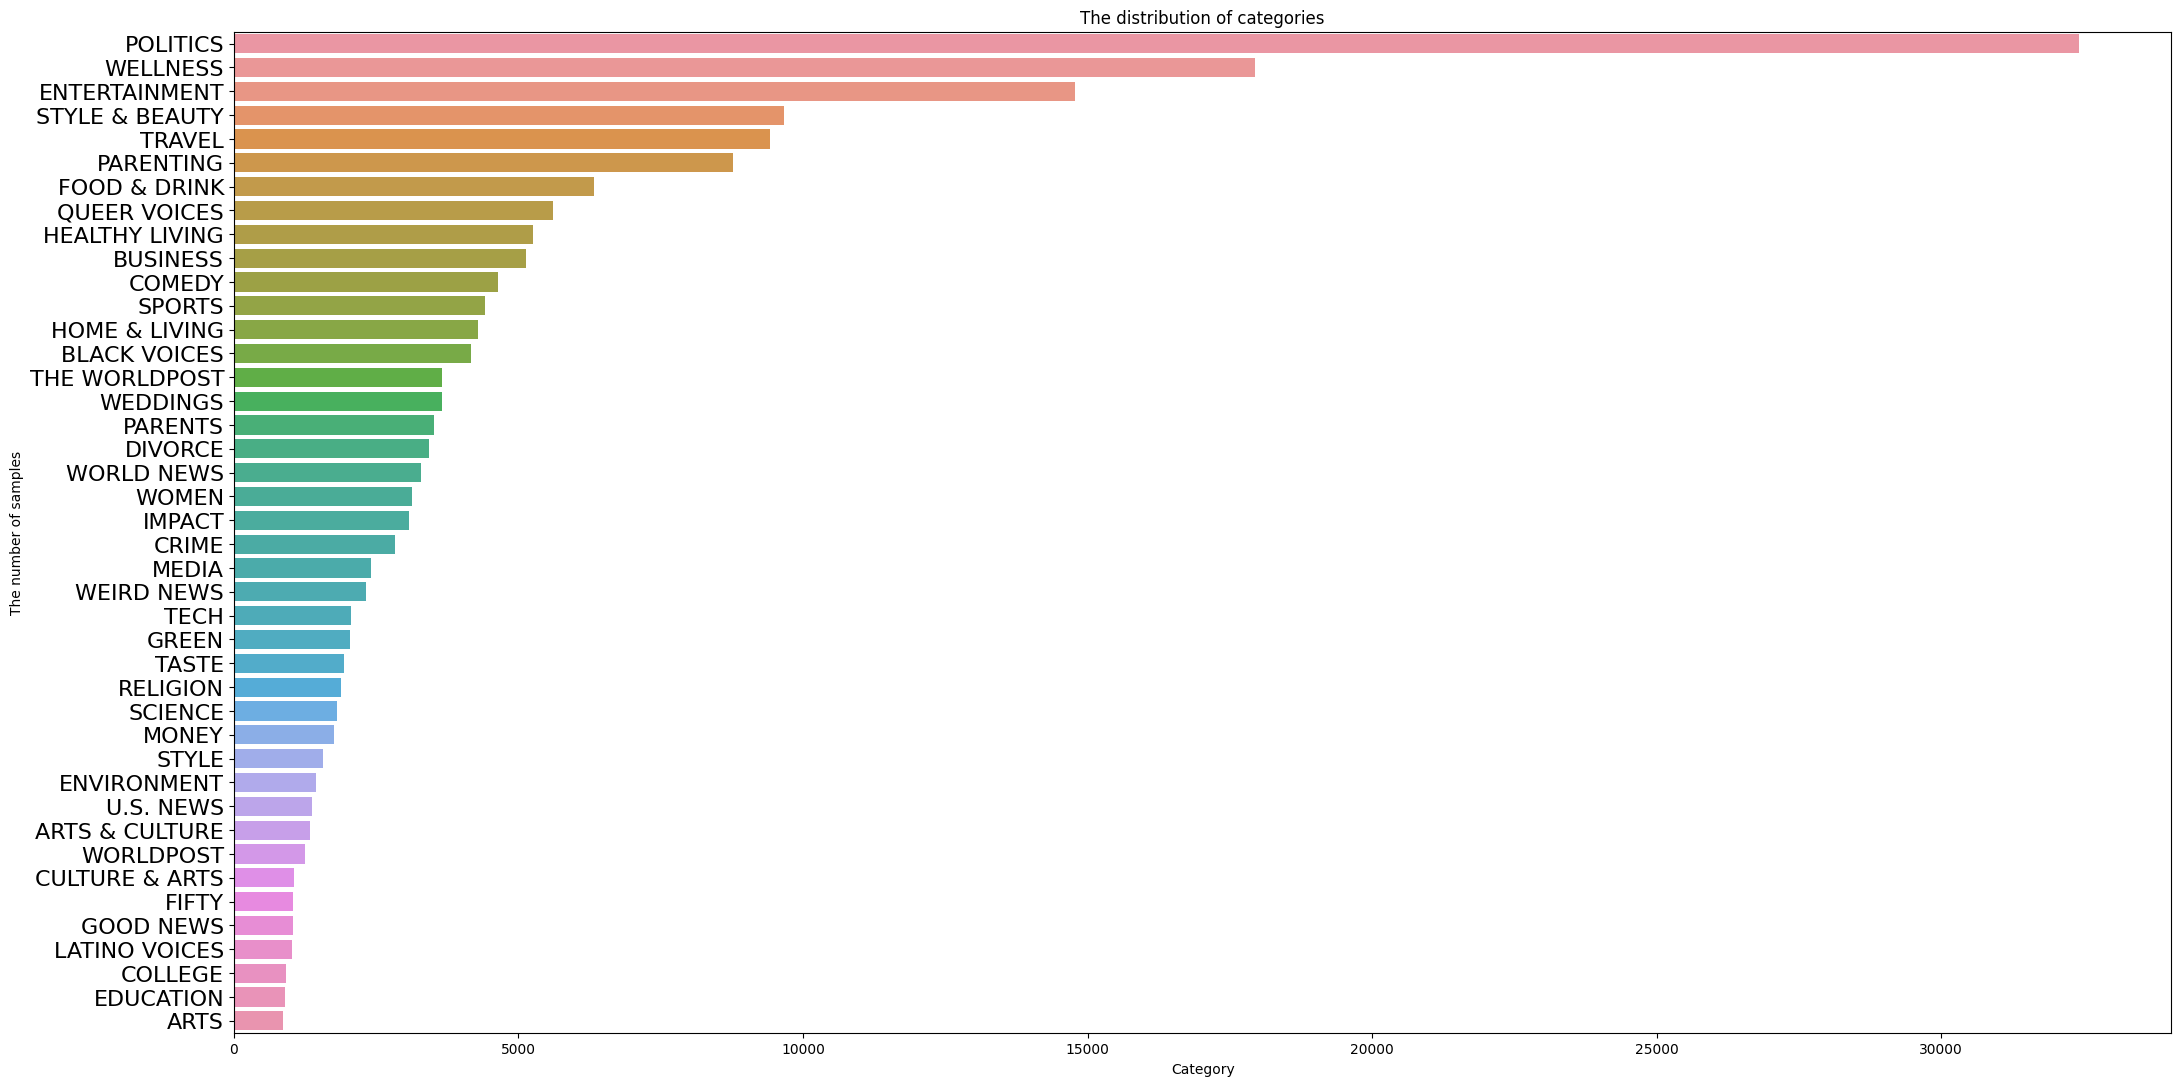

In [100]:
plt.figure(figsize=(25,13))
sns.barplot(y=data['category'].value_counts().index,x=data['category'].value_counts().values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 16)
plt.show()

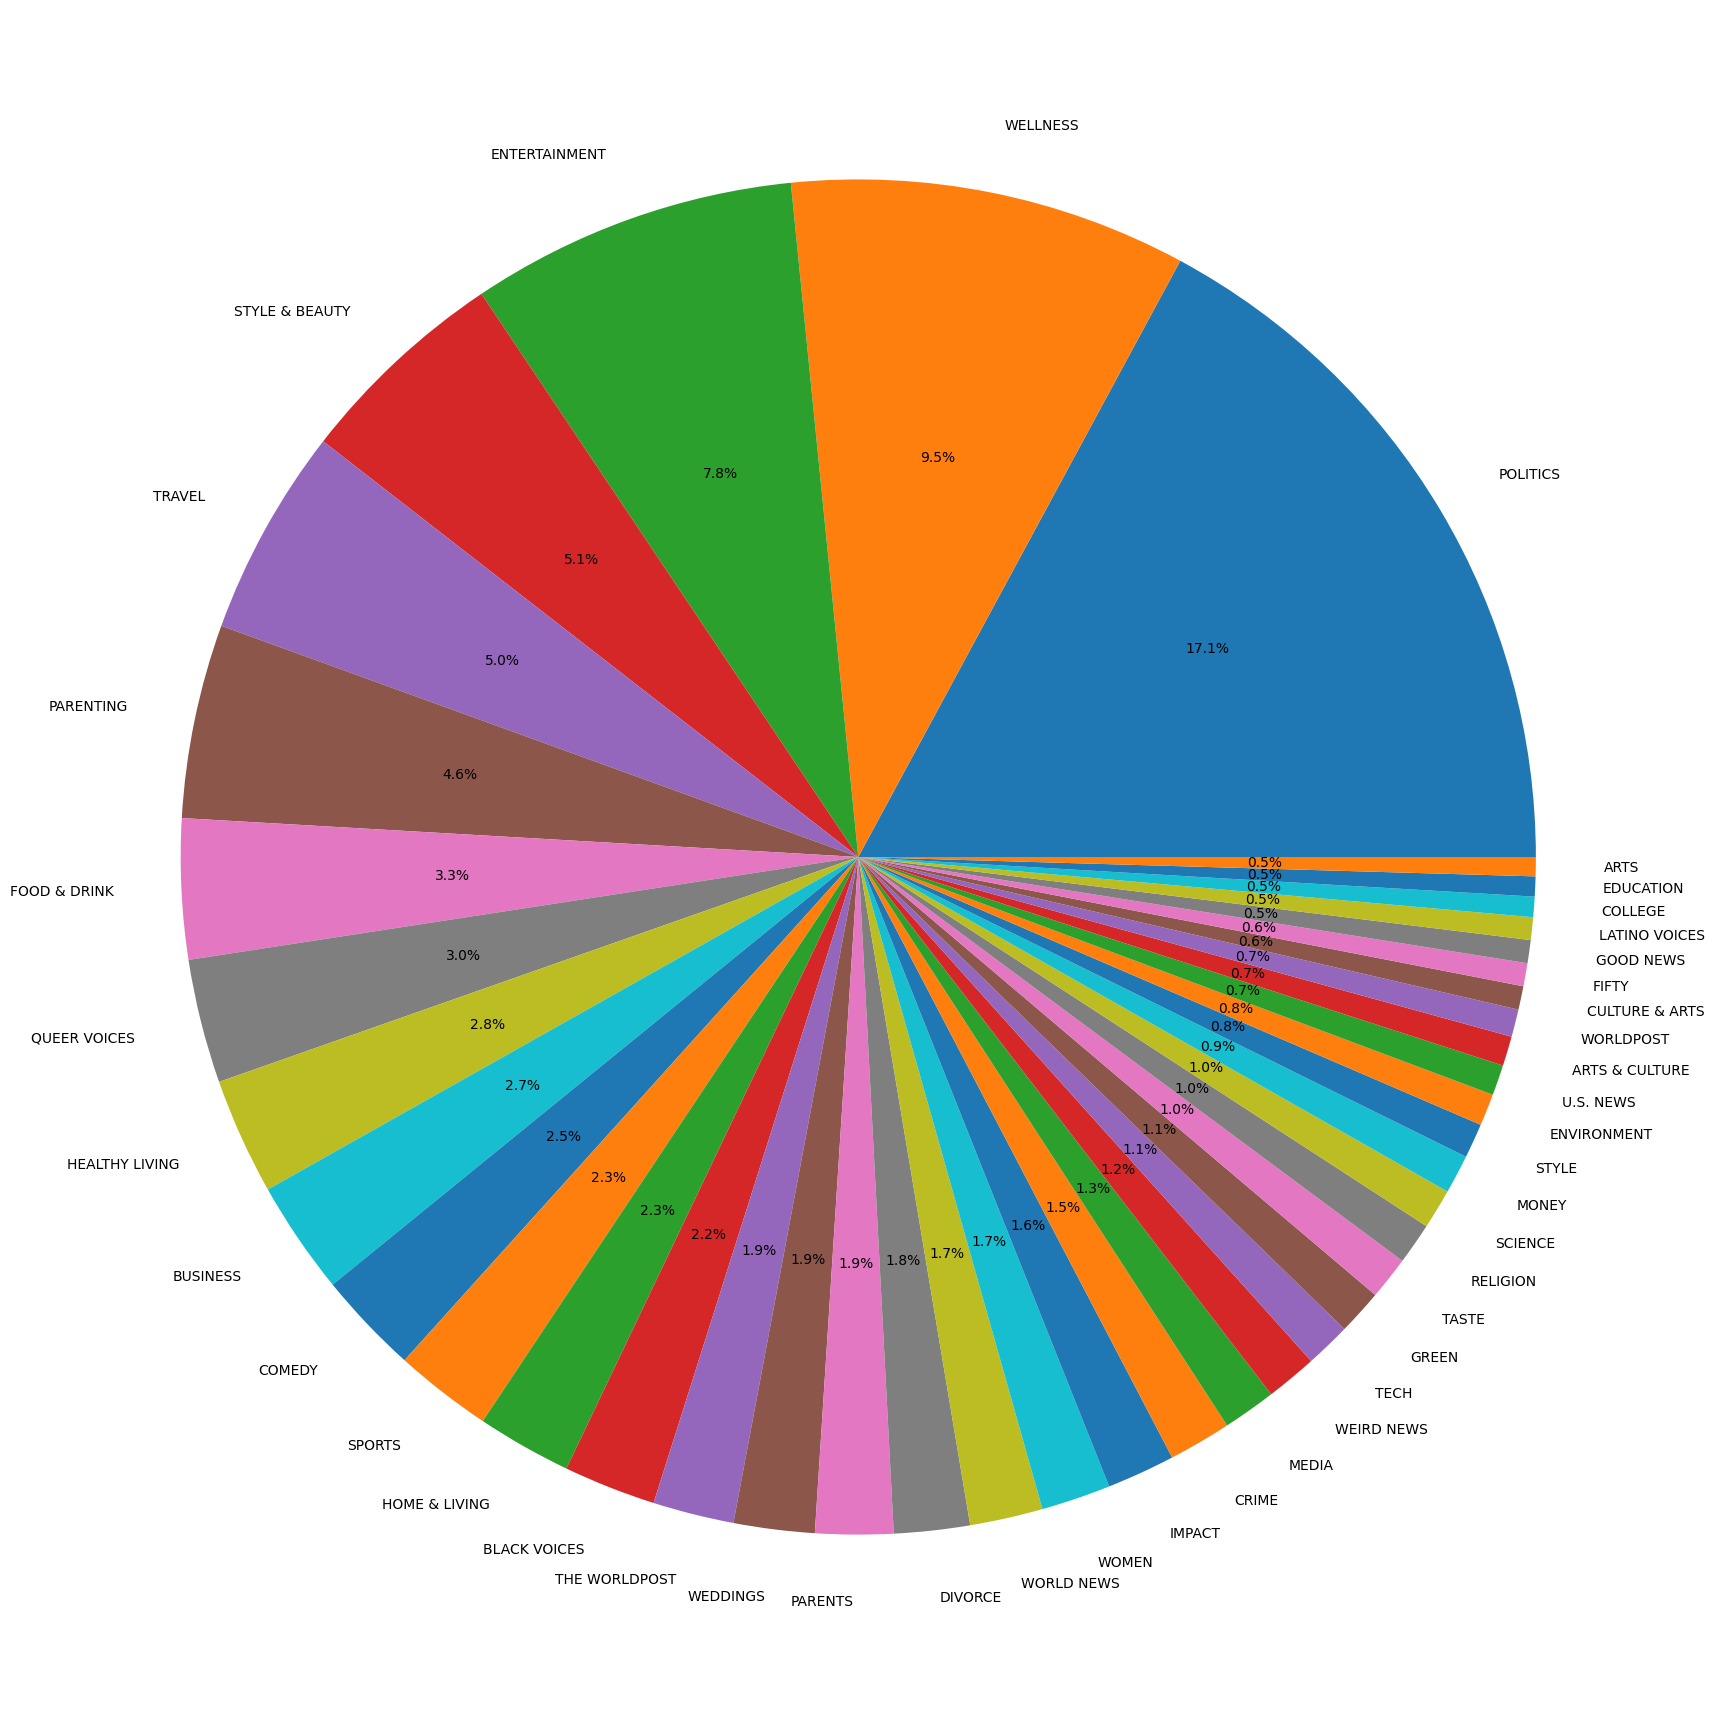

In [101]:
plt.figure(figsize=(22,22))
plt.pie(data['category'].value_counts().values, autopct="%1.1f%%", labels=data['category'].value_counts().index)
plt.show()

It is clear that the data is imbalanced with Politics having the maximum number of articles followed by Wellness and Entertainment

To carry on with the analysis, it is logical to concatenate 'headline' and 'short_description' columns

In [102]:
data['full_article'] = data['headline'] + " " + data['short_description']
data.head()

,headline,category,short_description,authors,date,full_article
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...


In [103]:
data['news_len'] = data['full_article'].apply(lambda x: len(x))
data.head()

,headline,category,short_description,authors,date,full_article,news_len
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,231
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",249
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,134
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,216
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,234


In [104]:
data.groupby('category')['news_len'].mean().reset_index().sort_values(by='news_len',ascending=False)

,category,news_len
41,WORLDPOST,314.991143
12,FIFTY,298.285029
0,ARTS,273.446118
9,EDUCATION,241.461197
18,IMPACT,227.655754
38,WELLNESS,226.120582
4,COLLEGE,222.533116
22,PARENTING,217.721981
21,MONEY,214.104843
7,CULTURE & ARTS,213.543315


It is better to calculate the mean instead of max or min as the mean gives a better understanding of the average length of news article(headline + short_description) for each category

{'whiskers': [<matplotlib.lines.Line2D at 0x791c0d753b80>,
 'caps': [<matplotlib.lines.Line2D at 0x791c45754100>,
 'boxes': [<matplotlib.lines.Line2D at 0x791c0d7538e0>],
 'medians': [<matplotlib.lines.Line2D at 0x791c45754640>],
 'fliers': [<matplotlib.lines.Line2D at 0x791c457548e0>],
 'means': []}

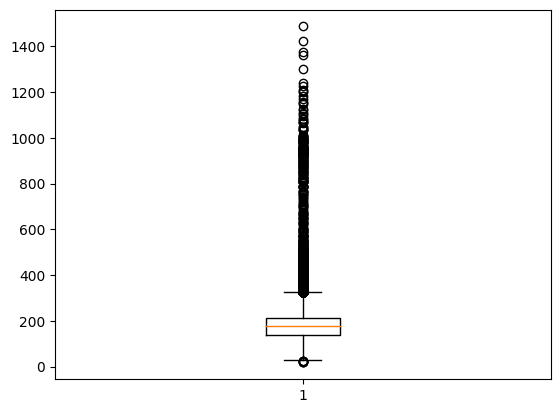

In [105]:
plt.boxplot(data['news_len'])

The Boxplot shows that there are mamny outliers in the data and thus it is important to remove them for the data to be normally distributed

In [106]:
data.reset_index(inplace = True, drop = True)

In [107]:
count = 0
max_threshold = data['news_len'].std() *3 + data['news_len'].mean()
min_threshold = abs(data['news_len'].mean() - data['news_len'].std()*3)
for num in data['news_len']:
    if num > max_threshold or num < min_threshold:
      count += 1
print("The total outliers are = ",count)

The total outliers are =  1151


Any value that lies beyond the threshold is consider an outlier. Threshold is distance of 3 standard deviations(3*std) from the mean. This is because for a normally distributed data, 99% of the values lie within 3 standard deviations from the mean

In [108]:
new_data = data[(data['news_len'] < max_threshold) & (data['news_len'] > min_threshold )]
new_data.shape

(188275, 7)

{'whiskers': [<matplotlib.lines.Line2D at 0x791c0d6574f0>,
 'caps': [<matplotlib.lines.Line2D at 0x791c0d657a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x791c0d657250>],
 'medians': [<matplotlib.lines.Line2D at 0x791c0d657f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x791c11464250>],
 'means': []}

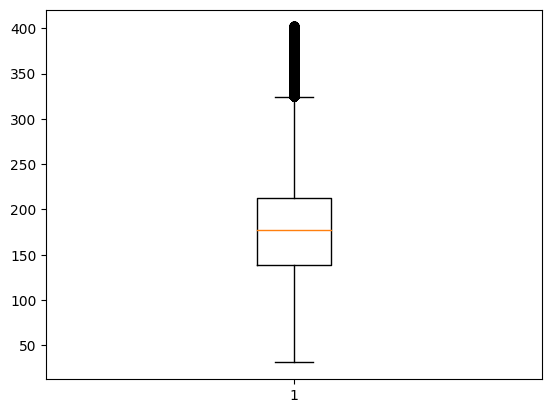

In [109]:
plt.boxplot(new_data['news_len'])

# Text Preprocessing

A function to preprocess the content of news articles

In [112]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower() #To convert to lowercase

    tokens = nltk.word_tokenize(text) #Inorder to tokenize the text into word tokens

    tokens = [token for token in tokens if token.isalpha()] #Remove puncutations and numbers

    tokens = [token for token in tokens if token not in stop_words] #Remove Stopwords

    tokens = [lemmatizer.lemmatize(token) for token in tokens] #Lemmitization

    return tokens

In [113]:
new_data.loc[:, ('full_article_tokens')] = new_data.loc[:,('full_article')].apply(lambda x: preprocess(x))

/tmp/ipykernel_31/1253243685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.loc[:, ('full_article_tokens')] = new_data.loc[:,('full_article')].apply(lambda x: preprocess(x))


In [114]:
new_data.tail()

,headline,category,short_description,authors,date,full_article,news_len,full_article_tokens
189421,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,183,"[rim, ceo, thorsten, heins, plan, blackberry, ..."
189422,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...,192,"[maria, sharapova, stunned, victoria, azarenka..."
189423,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28,"Giants Over Patriots, Jets Over Colts Among M...",221,"[giant, patriot, jet, colt, among, improbable,..."
189424,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...,174,"[aldon, smith, arrested, linebacker, busted, d..."
189425,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS,The five-time all-star center tore into his te...,,2012-01-28,Dwight Howard Rips Teammates After Magic Loss ...,179,"[dwight, howard, rip, teammate, magic, loss, h..."


# N-gram Analysis

Top 10 categories are considered for this analysis

In [115]:
unique_categories = pd.DataFrame(new_data['category'].value_counts().reset_index()[0:10])
top_unique_categories = unique_categories['category']

In [116]:
top_unique_categories

0          POLITICS
1          WELLNESS
2     ENTERTAINMENT
3    STYLE & BEAUTY
4            TRAVEL
5         PARENTING
6      FOOD & DRINK
7      QUEER VOICES
8    HEALTHY LIVING
9          BUSINESS
Name: category, dtype: object

In [117]:
categories_news_string = {}

# Iterate through unique categories and concatenate articles
for category in top_unique_categories:
    category_articles = list (new_data[new_data['category'] == category]['full_article_tokens'])
    categories_news_string[category] = list(np.concatenate(category_articles))

all_articles = pd.DataFrame(categories_news_string.items(), columns=['Category', 'News_tokens'])


In [118]:
all_articles

,Category,News_tokens
0,POLITICS,"[biden, say, force, would, defend, taiwan, chi..."
1,WELLNESS,"[sign, grinding, teeth, night, beyond, toothac..."
2,ENTERTAINMENT,"[golden, globe, returning, nbc, january, year,..."
3,STYLE & BEAUTY,"[hide, even, worst, tan, line, according, make..."
4,TRAVEL,"[lovely, honeymoon, destination, newlywed, tra..."
5,PARENTING,"[funniest, tweet, parent, week, accidentally, ..."
6,FOOD & DRINK,"[worker, lot, people, realize, many, school, e..."
7,QUEER VOICES,"[spirituality, new, face, queer, hell, meet, t..."
8,HEALTHY LIVING,"[people, say, tired, someone, asks, feel, like..."
9,BUSINESS,"[rei, worker, berkeley, store, vote, unionize,..."


In [119]:
all_articles.loc[:, ('unigram_Frequencies')] = all_articles['News_tokens'].apply(lambda x: nltk.FreqDist(x))
all_articles.head()

,Category,News_tokens,unigram_Frequencies
0,POLITICS,"[biden, say, force, would, defend, taiwan, chi...","{'biden': 688, 'say': 3427, 'force': 308, 'wou..."
1,WELLNESS,"[sign, grinding, teeth, night, beyond, toothac...","{'sign': 159, 'grinding': 4, 'teeth': 36, 'nig..."
2,ENTERTAINMENT,"[golden, globe, returning, nbc, january, year,...","{'golden': 144, 'globe': 134, 'returning': 27,..."
3,STYLE & BEAUTY,"[hide, even, worst, tan, line, according, make...","{'hide': 23, 'even': 280, 'worst': 163, 'tan':..."
4,TRAVEL,"[lovely, honeymoon, destination, newlywed, tra...","{'lovely': 18, 'honeymoon': 49, 'destination':..."


In [120]:
for (articles,category) in zip(all_articles['unigram_Frequencies'], all_articles['Category']):
    print(category)
    print(articles.most_common(10))

POLITICS
[('trump', 14152), ('donald', 4603), ('president', 3643), ('say', 3427), ('republican', 3007), ('state', 2693), ('new', 2608), ('said', 2566), ('gop', 2537), ('clinton', 2468)]
WELLNESS
[('life', 3139), ('health', 2233), ('time', 2189), ('one', 2102), ('people', 2038), ('study', 1977), ('way', 1917), ('u', 1799), ('new', 1781), ('day', 1714)]
ENTERTAINMENT
[('new', 1868), ('show', 1166), ('star', 1085), ('say', 1054), ('film', 1047), ('movie', 1024), ('trump', 1016), ('one', 974), ('year', 889), ('like', 814)]
STYLE & BEAUTY
[('photo', 5267), ('style', 2142), ('fashion', 2008), ('look', 1701), ('week', 1388), ('new', 1254), ('check', 1237), ('want', 1082), ('dress', 1060), ('sure', 943)]
TRAVEL
[('photo', 1870), ('travel', 1811), ('world', 1347), ('hotel', 1213), ('new', 1199), ('one', 1054), ('city', 1042), ('best', 1020), ('day', 834), ('time', 818)]
PARENTING
[('child', 2788), ('kid', 2538), ('parent', 1876), ('mom', 1329), ('baby', 1305), ('one', 1153), ('day', 1087), ('ti

The above output shows the 10 most common unigrams in each category

In [121]:
all_articles.loc[:,('bigram_Frequencies')] = all_articles['News_tokens'].apply(lambda x: nltk.FreqDist(list(nltk.bigrams(x))))
all_articles.head()

,Category,News_tokens,unigram_Frequencies,bigram_Frequencies
0,POLITICS,"[biden, say, force, would, defend, taiwan, chi...","{'biden': 688, 'say': 3427, 'force': 308, 'wou...","{('biden', 'say'): 35, ('say', 'force'): 4, ('..."
1,WELLNESS,"[sign, grinding, teeth, night, beyond, toothac...","{'sign': 159, 'grinding': 4, 'teeth': 36, 'nig...","{('sign', 'grinding'): 1, ('grinding', 'teeth'..."
2,ENTERTAINMENT,"[golden, globe, returning, nbc, january, year,...","{'golden': 144, 'globe': 134, 'returning': 27,...","{('golden', 'globe'): 127, ('globe', 'returnin..."
3,STYLE & BEAUTY,"[hide, even, worst, tan, line, according, make...","{'hide': 23, 'even': 280, 'worst': 163, 'tan':...","{('hide', 'even'): 1, ('even', 'worst'): 1, ('..."
4,TRAVEL,"[lovely, honeymoon, destination, newlywed, tra...","{'lovely': 18, 'honeymoon': 49, 'destination':...","{('lovely', 'honeymoon'): 1, ('honeymoon', 'de..."


In [122]:
for (articles,category) in zip(all_articles['bigram_Frequencies'], all_articles['Category']):
    print(category)
    print(articles.most_common(10))

POLITICS
[(('donald', 'trump'), 4481), (('hillary', 'clinton'), 1520), (('white', 'house'), 1207), (('supreme', 'court'), 858), (('bernie', 'sander'), 814), (('health', 'care'), 620), (('new', 'york'), 476), (('ted', 'cruz'), 432), (('morning', 'email'), 419), (('trump', 'administration'), 397)]
WELLNESS
[(('weight', 'loss'), 321), (('health', 'care'), 281), (('study', 'find'), 281), (('new', 'year'), 266), (('breast', 'cancer'), 235), (('new', 'study'), 222), (('gps', 'guide'), 220), (('lost', 'pound'), 214), (('study', 'suggests'), 191), (('sometimes', 'take'), 169)]
ENTERTAINMENT
[(('donald', 'trump'), 464), (('box', 'office'), 321), (('taylor', 'swift'), 283), (('kim', 'kardashian'), 200), (('kanye', 'west'), 167), (('new', 'york'), 158), (('chrissy', 'teigen'), 129), (('golden', 'globe'), 127), (('film', 'festival'), 125), (('miley', 'cyrus'), 124)]
STYLE & BEAUTY
[(('sure', 'check'), 770), (('want', 'sure'), 762), (('twitter', 'facebook'), 748), (('huffpost', 'style'), 691), (('f

The above output shows the 10 most common bigrams in each category

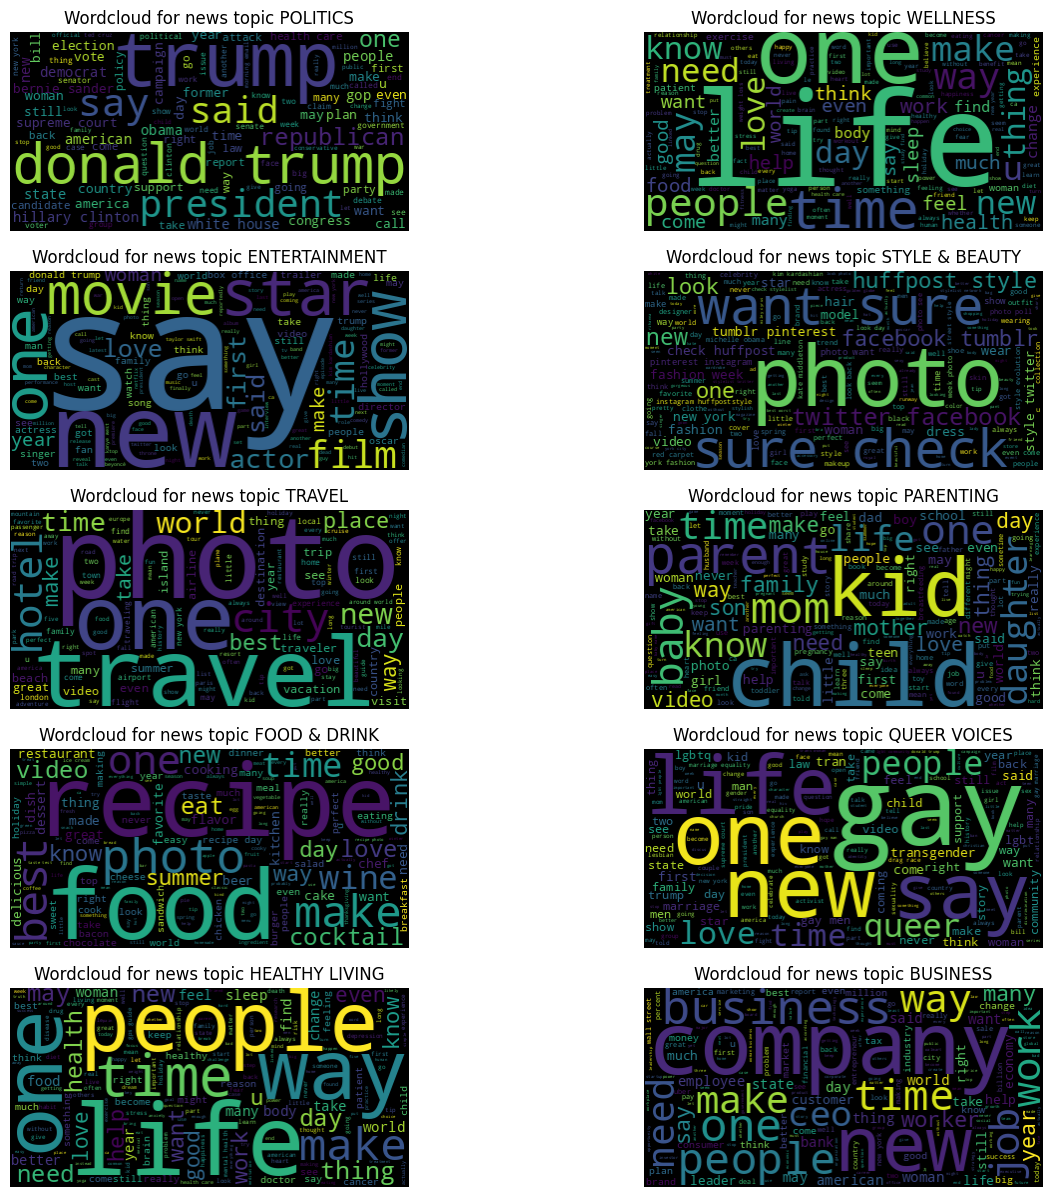

In [123]:
plt.figure(figsize=(15,15))

for i, category in enumerate(top_unique_categories):
    plt.subplot(5,2,i+1)
    cloud = WordCloud().generate(' '.join(all_articles['News_tokens'][i]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {category}")
    plt.axis('off')

# Classification

It is better to drop the author and the date columns as they are of no use for this analysis

In [124]:
new_data.drop(['authors','date'], axis=1, inplace = True)
new_data.head()

/tmp/ipykernel_31/769138029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(['authors','date'], axis=1, inplace = True)


,headline,category,short_description,full_article,news_len,full_article_tokens
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...,231,"[million, american, roll, sleeve, covid, boost..."
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li...",249,"[american, airline, flyer, charged, banned, li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...,134,"[funniest, tweet, cat, dog, week, dog, underst..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...,216,"[funniest, tweet, parent, week, accidentally, ..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...,234,"[woman, called, cop, black, loses, lawsuit, am..."


In [125]:
new_data['category'].value_counts()

category
POLITICS          32186
WELLNESS          17863
ENTERTAINMENT     14736
STYLE & BEAUTY     9643
TRAVEL             9317
PARENTING          8743
FOOD & DRINK       6323
QUEER VOICES       5561
HEALTHY LIVING     5192
BUSINESS           5079
COMEDY             4629
SPORTS             4402
HOME & LIVING      4271
BLACK VOICES       4153
THE WORLDPOST      3664
WEDDINGS           3649
PARENTS            3497
DIVORCE            3419
WORLD NEWS         3295
WOMEN              3114
IMPACT             3040
CRIME              2824
MEDIA              2392
WEIRD NEWS         2316
TECH               2051
GREEN              2014
TASTE              1940
RELIGION           1862
SCIENCE            1790
MONEY              1754
STYLE              1563
ENVIRONMENT        1440
U.S. NEWS          1377
ARTS & CULTURE     1338
WORLDPOST          1117
CULTURE & ARTS     1061
GOOD NEWS          1039
LATINO VOICES      1016
FIFTY               958
COLLEGE             911
EDUCATION           894
ARTS   

Since the data is extremely imbalanced, it is very difficult and tricky to implement simple classifiers that will give high accuracy. Thus for the purpose of this analysis, top 3 categories ("POLITICS","WELLNESS","ENTERTAINMENT") will only be considered.
The data is also resampled to make sure all the categories as in equal proportion

In [126]:
balanced_data = pd.DataFrame()
for category in ('POLITICS','WELLNESS','ENTERTAINMENT'):
  data_temp = new_data[new_data['category'] == category]
  data_temp = (resample(data_temp, replace=False, n_samples=10000, random_state=123))
  balanced_data = pd.concat([balanced_data,data_temp])

In [127]:
balanced_data['category'].value_counts()

category
POLITICS         10000
WELLNESS         10000
ENTERTAINMENT    10000
Name: count, dtype: int64

In [128]:
X = balanced_data.loc[:,new_data.columns != 'category']
X.head()

,headline,short_description,full_article,news_len,full_article_tokens
64762,Hillary Clinton And Bernie Sanders Vie For Cal...,Polls show Sanders has chipped away at Clinton...,Hillary Clinton And Bernie Sanders Vie For Cal...,131,"[hillary, clinton, bernie, sander, vie, califo..."
48283,Rebuilding The Democratic Machine,The Democratic Party is not dead. But the 2016...,Rebuilding The Democratic Machine The Democrat...,127,"[rebuilding, democratic, machine, democratic, ..."
52364,"2016 Election Finds Women Making History, Men ...",This election makes a good case for banning men.,"2016 Election Finds Women Making History, Men ...",124,"[election, find, woman, making, history, men, ..."
27329,Horrified Over Charlottesville? Start Planning...,The white nationalist/white supremacist violen...,Horrified Over Charlottesville? Start Planning...,192,"[horrified, charlottesville, start, planning, ..."
64007,Thousands Attend Orlando Vigil To Prove That L...,"""We are heartbroken, but our community is stro...",Thousands Attend Orlando Vigil To Prove That L...,105,"[thousand, attend, orlando, vigil, prove, love..."


In [129]:
y = balanced_data['category']

In [130]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X, y, random_state=1, test_size = 0.30, train_size = 0.7, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=1, test_size = 0.3, train_size = 0.7, stratify=y_train_plus_valid)

In [131]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(14699, 5)
(6300, 5)
(9000, 5)


The data is split into 3 sets, training, validation and test. The training set contains almost 50% of the clean data, validation set contains almost 20% of the clean data and test set contains almost 30% of the clean data.
The data is divided in such percentage because training data should be the highest as the model needs to be trained on a good amount of data. Validation set data is used to fine-tune the model and thus 20% data is sufficient for that. The test set is used for final testing and thus has 30% of the data.

In [132]:
#Using CountVectorizer to convert text data into numerical representation
vectorizer = CountVectorizer(max_features = 10000)

In [133]:
X_train_vectorized = vectorizer.fit_transform(X_train['full_article_tokens'].apply(lambda x: ' '.join(x)))
X_valid_vectorized = vectorizer.transform(X_valid['full_article_tokens'].apply(lambda x: ' '.join(x)))
X_test_vectorized = vectorizer.transform(X_test['full_article_tokens'].apply(lambda x: ' '.join(x)))

In [134]:
encoder = LabelEncoder()

In [135]:
y_train_encoded = encoder.fit_transform(y_train)
y_valid_encoded = encoder.transform(y_valid)
y_test_encoded = encoder.transform(y_test)

## Naive Bayes

In [136]:
nb_grid = MultinomialNB()

In [137]:
nb_param_grid = {
    'alpha' : [1,5,7],
    'fit_prior' : [True,False],
}

In [138]:
CV_nb = GridSearchCV(estimator=nb_grid, param_grid=nb_param_grid, cv= 5)
CV_nb.fit(X_train_vectorized, y_train_encoded)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [1, 5, 7], 'fit_prior': [True, False]})

In [139]:
print(CV_nb.best_params_)

{'alpha': 1, 'fit_prior': True}


In [140]:
nb = MultinomialNB()
nb.fit(X_train_vectorized, y_train_encoded)

MultinomialNB()

## Logistic Regression

In [141]:
lg_grid = LogisticRegression()

In [142]:
lg_param_grid ={
    'C': [0.5, 1, 1.5],
    'solver': ['lbfgs', 'sag', 'saga','newton=cg']
}

In [143]:
CV_lg = GridSearchCV(estimator=lg_grid, param_grid=lg_param_grid, cv= 5)
CV_lg.fit(X_train_vectorized, y_train_encoded)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 1, 1.5],
                         'solver': ['lbfgs', 'sag', 'saga', 'newton=cg']})

In [144]:
print(CV_lg.best_params_)

{'C': 0.5, 'solver': 'saga'}


In [145]:
lg = LogisticRegression(C= 0.5, solver = 'saga')
lg.fit(X_train_vectorized, y_train_encoded)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.5, solver='saga')

## Random Forest

In [146]:
rand_grid = RandomForestClassifier()

In [147]:
rand_param_grid = {
    'n_estimators': [100,200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [10,20,25],
    'criterion' :['gini', 'entropy']
}

In [148]:
CV_rand = GridSearchCV(estimator=rand_grid, param_grid=rand_param_grid, cv= 5)
CV_rand.fit(X_train_vectorized, y_train_encoded)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 25],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]})

In [149]:
print(CV_rand.best_params_)

{'criterion': 'gini', 'max_depth': 25, 'max_features': 'log2', 'n_estimators': 500}


In [151]:
rand = RandomForestClassifier(criterion = 'gini', max_depth = 25, max_features = 'log2', n_estimators = 500)
rand.fit(X_train_vectorized, y_train_encoded)

RandomForestClassifier(max_depth=25, max_features='log2', n_estimators=500)

## Support Vector Classifier

In [152]:
svc_grid = SVC()

In [153]:
svc_param_grid = {
    'kernel':['linear', 'rbf', 'sigmoid', 'poly'],
    'C':[0.5,1,1.5]
    }

In [154]:
CV_svc = GridSearchCV(estimator=svc_grid, param_grid=svc_param_grid, cv= 5)
CV_svc.fit(X_train_vectorized, y_train_encoded)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.5, 1, 1.5],
                         'kernel': ['linear', 'rbf', 'sigmoid', 'poly']})

In [155]:
print(CV_svc.best_params_)

{'C': 1.5, 'kernel': 'sigmoid'}


In [156]:
svc = SVC(C = 1.5, kernel = 'sigmoid')
svc.fit(X_train_vectorized, y_train_encoded)

SVC(C=1.5, kernel='sigmoid')

## Evaluation

In [157]:
train_max = -1
valid_max = -1
for model in (nb,lg,rand,svc):
  y_train_pred = model.predict(X_train_vectorized)
  y_valid_pred = model.predict(X_valid_vectorized)
  train_acc = accuracy_score(y_train_encoded,y_train_pred)
  print("Training accuray of ", model, " = " ,train_acc)
  if train_acc > train_max:
    train_max = train_acc
    good_train_model = model
  valid_acc = accuracy_score(y_valid_encoded,y_valid_pred)
  print("Validation accuray of ", model, " = " , valid_acc)
  if valid_acc > valid_max:
    valid_max = valid_acc
    good_valid_model = model


print(good_train_model, " gives the best accuracy score of ",train_max, " for training data")
print(good_valid_model, " gives the best accuracy score of ",valid_max, " for validation data")



Training accuray of  MultinomialNB()  =  0.9542145724198925
Validation accuray of  MultinomialNB()  =  0.9233333333333333
Training accuray of  LogisticRegression(C=0.5, solver='saga')  =  0.9910878291040207
Validation accuray of  LogisticRegression(C=0.5, solver='saga')  =  0.909047619047619
Training accuray of  RandomForestClassifier(max_depth=25, max_features='log2', n_estimators=500)  =  0.9509490441526635
Validation accuray of  RandomForestClassifier(max_depth=25, max_features='log2', n_estimators=500)  =  0.8922222222222222
Training accuray of  SVC(C=1.5, kernel='sigmoid')  =  0.944486019457106
Validation accuray of  SVC(C=1.5, kernel='sigmoid')  =  0.9023809523809524
LogisticRegression(C=0.5, solver='saga')  gives the best accuracy score of  0.9910878291040207  for training data
MultinomialNB()  gives the best accuracy score of  0.9233333333333333  for validation data


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4900
           1       0.99      0.99      0.99      4899
           2       1.00      1.00      1.00      4900

    accuracy                           0.99     14699
   macro avg       0.99      0.99      0.99     14699
weighted avg       0.99      0.99      0.99     14699



Text(0.5, 1.0, 'Confusion Matrix Training Set (LogisticRegression)')

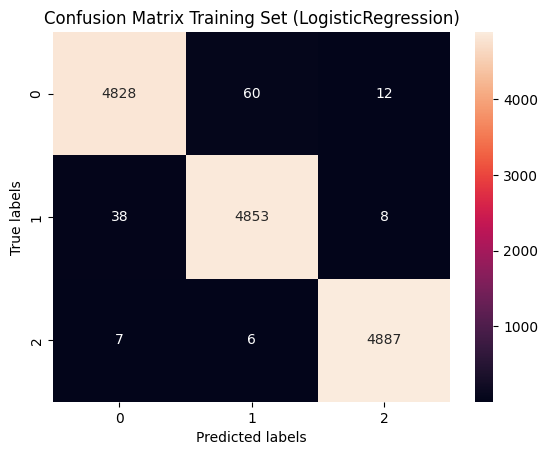

In [158]:
y_train_pred = good_train_model.predict(X_train_vectorized)
print(metrics.classification_report(y_train_encoded, y_train_pred))
cm=confusion_matrix(y_train_encoded,y_train_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Training Set (LogisticRegression)')

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2100
           1       0.91      0.92      0.92      2100
           2       0.94      0.95      0.94      2100

    accuracy                           0.92      6300
   macro avg       0.92      0.92      0.92      6300
weighted avg       0.92      0.92      0.92      6300



Text(0.5, 1.0, 'Confusion Matrix Validation Set (NaiveBayes)')

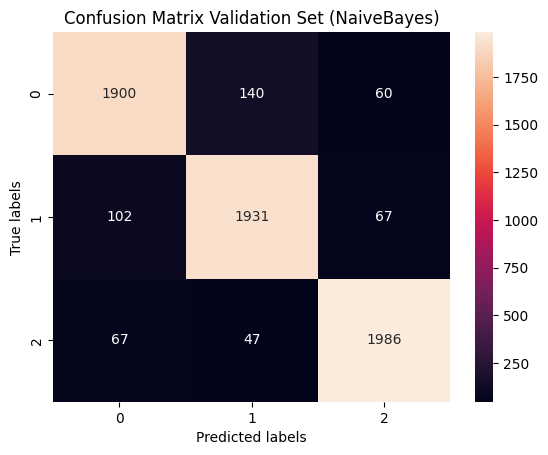

In [159]:
y_valid_pred = good_valid_model.predict(X_valid_vectorized)
print(metrics.classification_report(y_valid_encoded, y_valid_pred))
cm=confusion_matrix(y_valid_encoded,y_valid_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Validation Set (NaiveBayes)')

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      3000
           1       0.91      0.91      0.91      3000
           2       0.92      0.94      0.93      3000

    accuracy                           0.92      9000
   macro avg       0.92      0.92      0.92      9000
weighted avg       0.92      0.92      0.92      9000



Text(0.5, 1.0, 'Confusion Matrix Test Set (NaiveBayes)')

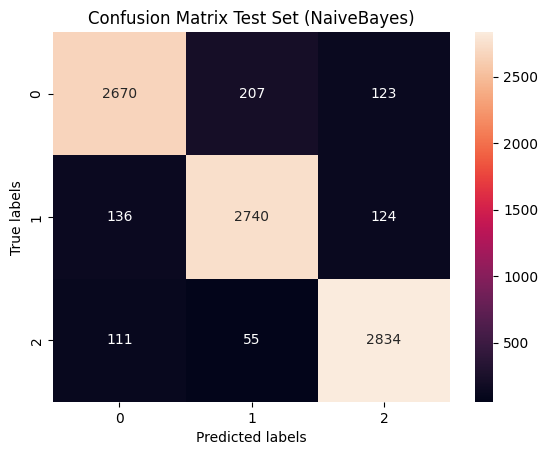

In [160]:
y_test_pred = good_valid_model.predict(X_test_vectorized)
print(metrics.classification_report(y_test_encoded, y_test_pred))
cm=confusion_matrix(y_test_encoded,y_test_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Test Set (NaiveBayes)')

## Neural Network

In [161]:
y_train_network = to_categorical(y_train_encoded, num_classes=3)
y_valid_network = to_categorical(y_valid_encoded, num_classes=3)

In [162]:
#Applying normalization
normal_X_train_vectorized = X_train_vectorized/X_train_vectorized.max()
normal_X_valid_vectorized = X_valid_vectorized/X_valid_vectorized.max()

In [163]:
model = Sequential()
model.add(Dense(input_shape=(10000,), units = 1012))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(505, kernel_regularizer=l2(0.05)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(158,  kernel_regularizer=l2(0.05)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(42, kernel_regularizer=l2(0.05)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1012)              10121012  
                                                                 
 activation (Activation)     (None, 1012)              0         
                                                                 
 dropout (Dropout)           (None, 1012)              0         
                                                                 
 dense_1 (Dense)             (None, 505)               511565    
                                                                 
 activation_1 (Activation)   (None, 505)               0         
                                                                 
 dropout_1 (Dropout)         (None, 505)               0         
                                                                 
 dense_2 (Dense)             (None, 158)               7

In [164]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [165]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [166]:
history = model.fit(np.asfarray(normal_X_train_vectorized.toarray()), np.asfarray(y_train_network), \
          epochs=15, batch_size=1100, verbose=1, callbacks=[early_stopping],  \
          validation_data=(np.asfarray(normal_X_valid_vectorized.toarray()), np.asfarray(y_valid_network)))

Epoch 1/15
14/14 [==============================] - 7s 462ms/step - loss: 39.0678 - accuracy: 0.5636 - val_loss: 27.2369 - val_accuracy: 0.7856
Epoch 2/15
14/14 [==============================] - 6s 428ms/step - loss: 20.7641 - accuracy: 0.7949 - val_loss: 14.1083 - val_accuracy: 0.8330
Epoch 3/15
14/14 [==============================] - 6s 422ms/step - loss: 10.7616 - accuracy: 0.8350 - val_loss: 7.3503 - val_accuracy: 0.8410
Epoch 4/15
14/14 [==============================] - 6s 429ms/step - loss: 5.7458 - accuracy: 0.8737 - val_loss: 4.0527 - val_accuracy: 0.8738
Epoch 5/15
14/14 [==============================] - 6s 423ms/step - loss: 3.3077 - accuracy: 0.9120 - val_loss: 2.4820 - val_accuracy: 0.8943
Epoch 6/15
14/14 [==============================] - 6s 462ms/step - loss: 2.1169 - accuracy: 0.9302 - val_loss: 1.6983 - val_accuracy: 0.9092
Epoch 7/15
14/14 [==============================] - 6s 432ms/step - loss: 1.4990 - accuracy: 0.9416 - val_loss: 1.2792 - val_accuracy: 0.9156
E

## Neural Network Evaluation

460/460 [==============================] - 6s 14ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      4900
           1       0.96      0.97      0.97      4899
           2       0.93      1.00      0.96      4900

    accuracy                           0.96     14699
   macro avg       0.96      0.96      0.96     14699
weighted avg       0.96      0.96      0.96     14699



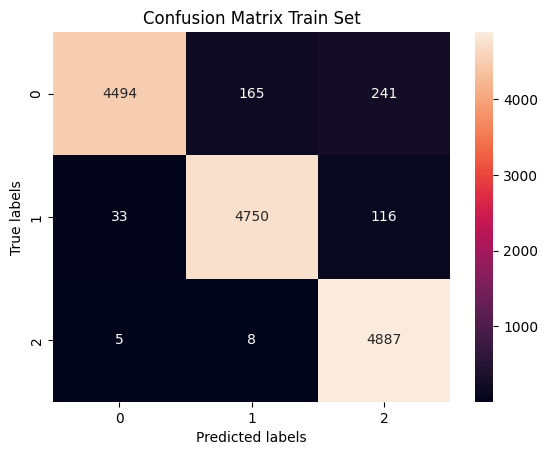

In [167]:
y_train_pred = model.predict(np.asfarray(X_train_vectorized.toarray()))
classes = np.argmax(y_train_pred,axis=1)
print(metrics.classification_report(y_train_encoded, classes))
cm=confusion_matrix(y_train_encoded, classes)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Train Set');

197/197 [==============================] - 3s 14ms/step
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      2100
           1       0.91      0.90      0.90      2100
           2       0.84      0.98      0.91      2100

    accuracy                           0.90      6300
   macro avg       0.90      0.90      0.90      6300
weighted avg       0.90      0.90      0.90      6300



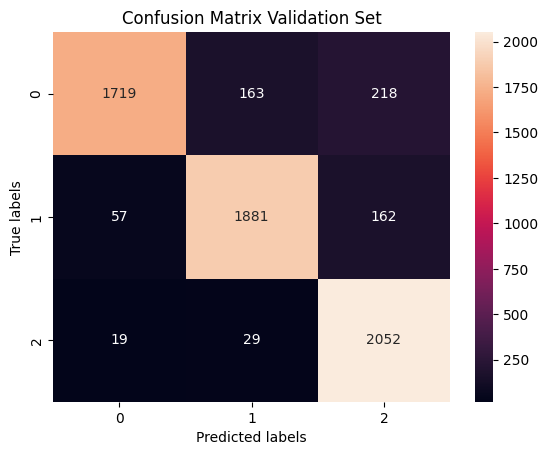

In [168]:
y_valid_pred = model.predict(np.asfarray(X_valid_vectorized.toarray()))
classes = np.argmax(y_valid_pred,axis=1)
print(metrics.classification_report(y_valid_encoded, classes))
cm=confusion_matrix(y_valid_encoded, classes)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Validation Set');

282/282 [==============================] - 4s 14ms/step
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      3000
           1       0.91      0.90      0.90      3000
           2       0.83      0.98      0.90      3000

    accuracy                           0.89      9000
   macro avg       0.90      0.89      0.89      9000
weighted avg       0.90      0.89      0.89      9000



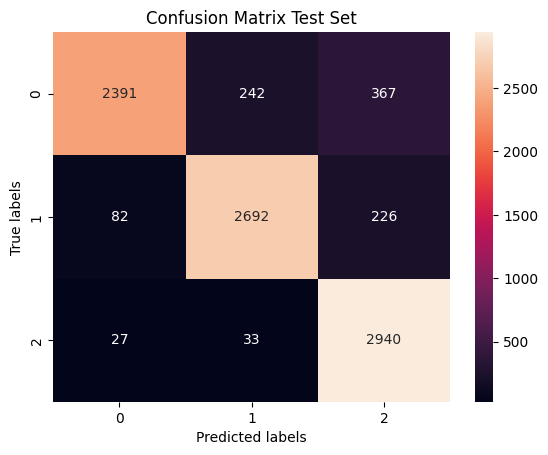

In [169]:
y_test_pred = model.predict(np.asfarray(X_test_vectorized.toarray()))
classes = np.argmax(y_test_pred,axis=1)
print(metrics.classification_report(y_test_encoded, classes))
cm=confusion_matrix(y_test_encoded, classes)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Test Set');

# Conclusion

For the purpose of this analysis, the data was explored and it was found that it is highly imbalanced. N-gram analysis was also carried out to understand the content in each category.

It is exteremely tricky to build a model that can classify all the 42 categories with high accuracy and also the aim was to explore, compare and contrast different types of classifiers to find out which one works the best on textual data. A simple neural network was also created for this classification to further compare with naive bayers. It is evident from the evaluation that naive bayers classifier performed the best out of all the classifiers and also the neural network.

It is true that the neural network which was implemented did not perfrom better than the naive bayes classifier but it did perform better than or equal to the other classifiers. After fine tunining it further, it would have perfromed better than naive bayes as well. But for now naive bayes classifier is the winner.